# AIM

DQN  
Breakout-v0

# REFERENCE

* [https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

In [1]:
import copy
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib nbagg
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, optimizers, Variable, serializers
import cv2

In [26]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "matplotlib", "gym", "opencv-python"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
matplotlib 2.0.2
gym 0.9.2
opencv-python 3.3.0.9


In [27]:
env = gym.make("Breakout-v0")

[2017-09-03 11:55:16,235] Making new env: Breakout-v0


(210, 160, 3) [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


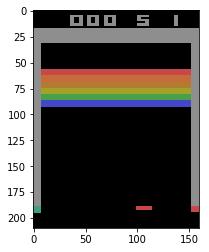

In [28]:
%matplotlib inline

pobs = env.reset()

# 次元の確認
print(pobs.shape, pobs)

# 画面の確認
plt.imshow(pobs)
plt.show()

デフォルト


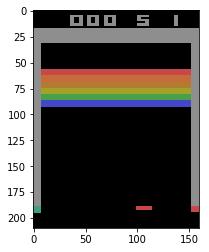

グレースケールに変換


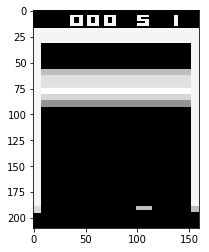

リサイズ
(210, 160)
(105, 80)


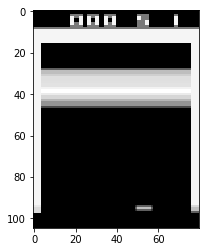

必要な部分のみにカット
(50, 70)


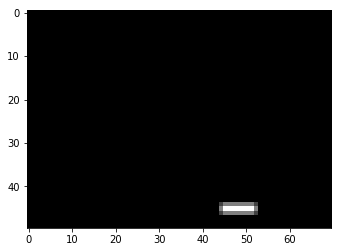

In [29]:
%matplotlib inline

pobs = env.reset()

print("デフォルト")
plt.imshow(pobs, cmap="gray")
plt.show()

print("グレースケールに変換")
pobs = cv2.cvtColor(pobs, cv2.COLOR_RGB2GRAY)
plt.imshow(pobs, cmap="gray")
plt.show()

print("リサイズ")
print(pobs.shape)
height, width = pobs.shape
size = (int(width * 0.5), int(height * 0.5))
pobs = cv2.resize(pobs, size)
print(pobs.shape)
plt.imshow(pobs, cmap="gray")
plt.show()

print("必要な部分のみにカット")
pobs = pobs[50:100, 5:75]
print(pobs.shape)
plt.imshow(pobs, cmap="gray")
plt.show()

<IPython.core.display.Javascript object>


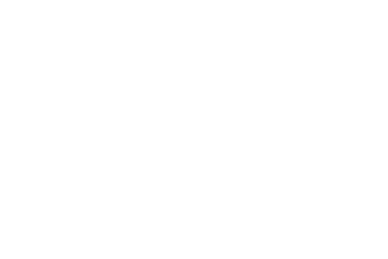

<IPython.core.display.Javascript object>


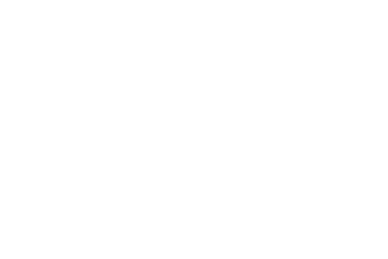

In [30]:
%matplotlib nbagg

fig = plt.figure()

pobs = env.reset()
im = plt.imshow(pobs, animated=True)

def render(*args):
    pobs, _, _, _ = env.step(env.action_space.sample())
    im.set_array(pobs)
    return im

ani = animation.FuncAnimation(fig, render, interval=10)
plt.show()

<IPython.core.display.Javascript object>


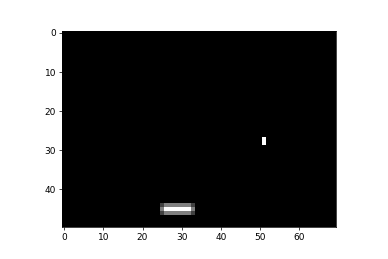

In [31]:
%matplotlib nbagg

fig = plt.figure()

def convert(obs):
    # グレースケール
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    # リサイズ
    height, width = obs.shape
    size = (int(width*0.5), int(height*0.5))
    obs = cv2.resize(obs, size)
    # カット
    obs = obs[50:100, 5:75]
    return obs

pobs = env.reset()
pobs = convert(pobs)
im = plt.imshow(pobs, cmap="gray", animated=True)

def render(*args):
    pobs, _, _, _ = env.step(env.action_space.sample())
    pobs = convert(pobs)
    im.set_array(pobs)
    return im

ani = animation.FuncAnimation(fig, render, interval=10)
plt.show()

In [ ]:
# 環境
env = gym.make("Breakout-v0")

# CNNクラス定義
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__(
            xc = L.Convolution2D(None, 48, (5, 70)),
            ch = L.Linear(1104, 300),
            hy = L.Linear(300, env.action_space.n)
        )
        
    def __call__(self, x):
        x = Variable(x)
        h = F.max_pooling_2d(F.relu(self.xc(x)), 2)
        h = F.relu(self.ch(h))
        y = F.relu(self.hy(h))
        return y
        
    def reset(self):
        self.zerograds()

# 画像変換関数定義
def convert(obs):
    # グレースケール
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    # リサイズ
    height, width = obs.shape
    size = (int(width*0.5), int(height*0.5))
    obs = cv2.resize(obs, size)
    # カット
    obs = obs[50:100, 5:75]
    # 正規化
    obs = obs/255
    # CNNが読み込める形式にする
    obs = np.array(obs, dtype="float32")
    return obs

# モデル
Q = CNN() # 近似Q関数
#serializers.load_npz("./******.npz", q) # 重みファイル読み込み
Q_ast = copy.deepcopy(Q)
optimizer = optimizers.Adam()
optimizer.setup(Q)

# 定数
EPOCH_NUM = 10000 # エポック数
MEMORY_SIZE = 1000 # メモリサイズいくつで学習を開始するか
BATCH_SIZE = 100 # バッチサイズ
EPSILON = 1 # ε-greedy法
EPSILON_DECREASE = 0.01 # εの減少値
EPSILON_MIN = 0.01 # εの下限
START_REDUCE_EPSILON = 10000 # εを減少させるステップ数
TRAIN_FREQ = 10 # Q関数の学習間隔
UPDATE_TARGET_Q_FREQ = 20 # Q関数の更新間隔
GAMMA = 0.99

total_step = 0 # 総ステップ（行動）数
memory = [] # メモリ
total_rewards = [] # 累積報酬記録用リスト
total_losses = [] # 累積誤差記録用リスト

# 学習開始
print("Train")
print("\t".join(["epoch", "EPSILON", "reward", "total_step", "loss", "elapsed_time"]))
start = time.time()
for epoch in range(EPOCH_NUM):
    pobs = env.reset() # 環境初期化
    pobs = convert(pobs)
    converted_height, converted_width = pobs.shape[0], pobs.shape[1] # 後で利用するので、変換後のサイズを取得
    done = False # ゲーム終了フラグ
    total_reward = 0 # 累積報酬
    total_loss = 0 # 累積誤差
    while not done:
        # 行動選択
        pact = env.action_space.sample()
        if np.random.rand() > EPSILON: # ε-greedy法
            pact = Q(pobs.reshape((1, 1, converted_height, converted_width))) # 最適な行動を予測 # batchsize, channel, height, width
            pact = np.argmax(pact.data)
        # 行動
        obs, reward, done, _ = env.step(pact)
        obs = convert(obs)
        # メモリに蓄積
        memory.append((pobs, pact, reward, obs, done)) # 変換済みの行動前状態ベクトル、未変換の行動ラベル、報酬、変換済みの行動後状態ベクトル、ゲーム終了フラグ
        if len(memory) > MEMORY_SIZE: # メモリサイズを超えていれば消していく
            memory.pop(0)
        # 学習
        if len(memory) == MEMORY_SIZE: # メモリサイズ分溜まっていれば学習
            # 経験リプレイ
            if total_step % TRAIN_FREQ == 0:
                np.random.shuffle(memory)
                memory_idx = range(len(memory))
                for i in memory_idx[::BATCH_SIZE]:
                    batch = np.array(memory[i:i+BATCH_SIZE]) # 経験ミニバッチ
                    pobss = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, 1, converted_height, converted_width))
                    pacts = np.array(batch[:,1].tolist(), dtype="int32")
                    rewards = np.array(batch[:,2].tolist(), dtype="int32")
                    obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, 1, converted_height, converted_width))
                    dones = np.array(batch[:,4].tolist(), dtype="bool")
                    # set y
                    q = Q(pobss)
                    maxq = list(map(np.max, Q_ast(obss).data)) # maxQ
                    target = copy.deepcopy(q.data)
                    for j in range(BATCH_SIZE):
                        target[j, pacts[j]] = rewards[j]+GAMMA*maxq[j]*(not dones[j])
                    # Perform a gradient descent step
                    Q.reset()
                    loss = F.mean_squared_error(q, Variable(target))
                    total_loss += loss.data
                    loss.backward()
                    optimizer.update()
            # Q関数の更新
            if total_step % UPDATE_TARGET_Q_FREQ == 0:
                Q_ast = copy.deepcopy(Q)
        # εの減少
        if EPSILON > EPSILON_MIN:
            if total_step > START_REDUCE_EPSILON:
                EPSILON -= EPSILON_DECREASE
        # 次の行動へ
        total_reward += reward
        total_step += 1
        pobs = obs
    total_rewards.append(total_reward) # 累積報酬を記録
    total_losses.append(total_loss) # 累積誤差を記録
    #serializers.save_npz("./******.npz", q) # 重みファイル出力
    if (epoch+1) % 10 == 0:
        elapsed_time = time.time()-start
        r = sum(total_rewards[((epoch+1)-10):(epoch+1)])
        l = sum(total_losses[((epoch+1)-10):(epoch+1)])
        print("\t".join(map(str,[epoch+1, EPSILON, r, total_step, l, str(elapsed_time)+"[sec]"]))) # ログ出力
        start = time.time()
        
plt.figure(figsize=(15,7))
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp, color="cyan")
plt.show()